# PGP AI - AI and Machine Learning Capstone Project

## Project 1 - E-Commerce

DESCRIPTION

Problem Statement

Amazon is an online shopping website that now caters to millions of people everywhere. Over 34,000 consumer reviews for Amazon brand products like Kindle, Fire TV Stick and more are provided. 
The dataset has attributes like brand, categories, primary categories, reviews.title, reviews.text, and the sentiment. Sentiment is a categorical variable with three levels "Positive", "Negative“, and "Neutral". For a given unseen data, the sentiment needs to be predicted.
You are required to predict Sentiment or Satisfaction of a purchase based on multiple features and review text.

> ***Author***
>
> ***Saikat Narayan Bhattacharjya***
>
> ***Email: <snbhattacharjya@gmail.com>***

### Required Libraries for the Project

In [1]:
import numpy as np
import pandas as pd

import re
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, classification_report
from scipy.sparse import hstack, csr_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### User Functions

#### load_data: `Loads the data from datasource and return a DataFrame`
@input: Path for the datafile

@Output: Pandas.DataFrame

In [2]:
def load_data(path=""):
    return pd.read_csv(path)

#### merge_data: `Concatenates the datasets and return a DataFrame`
@input: Array of Datasets

@Output: Pandas.DataFrame

In [3]:
def merge_data(datasets=[]):
    return pd.concat(datasets)

#### sample_data: `Returns a slice of DataFrame by RowCount`
@input: DataFrame

@Output: Slice of Dataframe by RowCount

In [4]:
def sample_data(data, row_count=5):
    return data[:row_count]

#### preprocess: `Text Processing steps in the sequence of: Word Tokenization, Removal of StopWords, Removal of Single character Words, Lemmatization. The output words are joined to from records and the list of such of records are returned. `
@input: List of Textual Data

@Output: List of Textual Data

In [5]:
def preprocess(data):
    data = [regexp_tokenize(record, pattern='[A-Za-z]\w+') 
                   for record in data]
    print("Completed Word Tokenization")

    data = [[word for word in text 
                    if word not in stopwords.words('english')] 
                   for text in data]
    print("Completed Removal of nltk StopWords")

    data = [[word for word in text 
                    if len(word) > 1] 
                   for text in data]
    print("Completed Removal of Words of length = 1")
    
    data = [[WordNetLemmatizer().lemmatize(word) for word in text] 
                   for text in data]
    print("Completed Lemmatization of Words")


    data_cleaned = []

    for record in data:
        sent = ""
        for word in record:
            sent = sent + word + " "
        data_cleaned.append(sent[:-1])

    print("Completed Joining of the cleaned Text into a record")
    
    print("Analysing Tokens:")
    token_analysis(data)
    
    return data_cleaned

#### token_analysis: `Prints and Plots top Ten(10) words in the Textual Records`
@input: 2 dim List of Words

@Output: Void

In [6]:
def token_analysis(data):
    terms = []

    for record in data:
        for word in record:
            terms.append(word)

    print("Total Tokens: {}".format(len(terms)))

    from collections import Counter

    counts_terms = Counter(terms)
    terms_df = pd.DataFrame(counts_terms.most_common(10), 
                            columns=['term', 'count'])
    terms_df

    terms_df.sort_values(by='count', 
                         ascending=True).plot(kind="barh", 
                                              x='term', 
                                              figsize=(12,10), 
                                              color='teal')
    plt.style.use('seaborn')
    plt.show()

#### create_dataset: `Returns Vectorized Feature and Label Data Set`
@input: Pandas.DataFrame, String(Feature Column), String(Label Column), Vectorizer Class

@Output: List(Vectorized Feture), List(Label)

In [7]:
def create_dataset(data, features, label, vectorizer):
    X = vectorizer.fit_transform(data[features].tolist())
    y = data[label].tolist()
    return X, y

#### resample_dataset: `Returns an Over or Under Sampled X, Y`
@input: Features, Labels

@Output: Sampled(Features), Sampled(Y)

In [8]:
def resample_dataset(X, y, sampler):
    return sampler.fit_sample(X, y)

#### create_model: `Returns a ML Model based on X, Y`
@input: X, Y, Model

@Output: Model

In [9]:
def create_model(X, y, model):
    return model.fit(X, y)

#### assess_model_score: `Returns a Score Matirx for the Model with a Sampling Strategy`
@input: ModelName, Model, Sampling, X_test, y_test

@Output: List of Scores for a Model with specified Sampling strategy

In [10]:
def assess_model_score(model_name, model, sampling, X_test, y_test):
    scores = []
    y_pred = model.predict(X_test)
    scores.append(model_name)
    scores.append(sampling)
    scores.append(f1_score(y_test, y_pred, average='weighted'))
    scores.append(accuracy_score(y_test, y_pred))
    scores.append(precision_score(y_test, y_pred, average='weighted'))
    scores.append(recall_score(y_test, y_pred, average='weighted'))
    #scores['ROC_AUC_Score'] = roc_auc_score(y_test, model.predict(X_test), average='weighted', multi_class ='ovr')
    
    return scores

### Week 1:
1. Perform an EDA on the dataset.
    a. See what a positive, negative, and neutral review looks like
    b. Check the class count for each class. It’s a class imbalance problem.
2. Convert the reviews in Tf-Idf score.
3. Run multinomial Naive Bayes classifier. Everything will be classified as positive because of the class imbalance.

### 1.  Exploratory Data Analysis 
        . Describing Datasets
        . Gaining information about feature columns
        . Analysing the reviews

#### Loading Datasets

In [11]:
train_df = load_data("datasets/train_data.csv")
test_data_hidden_df = load_data("datasets/test_data_hidden.csv")
test_df = load_data("datasets/test_data.csv")

#### Describing the Datasets

In [12]:
print("Train:")
train_df.info()
print("\nTest Data Hidden:")
test_data_hidden_df.info()
print("\nTest:")
test_df.info()

Train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               4000 non-null   object
 1   brand              4000 non-null   object
 2   categories         4000 non-null   object
 3   primaryCategories  4000 non-null   object
 4   reviews.date       4000 non-null   object
 5   reviews.text       4000 non-null   object
 6   reviews.title      3990 non-null   object
 7   sentiment          4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB

Test Data Hidden:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               1000 non-null   object
 1   brand              1000 non-null   object
 2   categories         1000 non-null   object
 3   primaryCate

#### Observation:
1. There are 4000 training samples and 1000 Test Samples
2. The files are separated into training and test datasets
3. For the Training we need to merge the training and test_data_hidden csv files
4. For testing we need to create a fourth file from test_data and test_data_hidden

In [13]:
merge_df = merge_data([train_df,test_data_hidden_df])

In [14]:
sample_data(merge_df,10)

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive
5,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2016-12-23T00:00:00.000Z,This is a great product. Light weight. I wish ...,You will love it,Positive
6,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-05-31T00:00:00.000Z,My 7-year old daughter saved up to by this. He...,OK For Entry Level Tablet,Neutral
7,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-06-05T00:00:00.000Z,Purchased this for my son. Has room to upgrade...,Great for kids or smaller needs,Positive
8,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-11-23T00:00:00.000Z,Bought this for my mom and it was just what sh...,Great tablet,Positive
9,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-05-18T00:00:00.000Z,"was cheap, can not run chrome stuff, returned ...","was cheap, can not run chrome stuff, returned",Negative


In [15]:
merge_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,5000,5000,5000,5000,5000,5000,4987,5000
unique,23,1,23,4,679,4385,3124,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,845,5000,797,3276,125,4,122,4686


In [16]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               5000 non-null   object
 1   brand              5000 non-null   object
 2   categories         5000 non-null   object
 3   primaryCategories  5000 non-null   object
 4   reviews.date       5000 non-null   object
 5   reviews.text       5000 non-null   object
 6   reviews.title      4987 non-null   object
 7   sentiment          5000 non-null   object
dtypes: object(8)
memory usage: 351.6+ KB


#### Analysing the Reviews

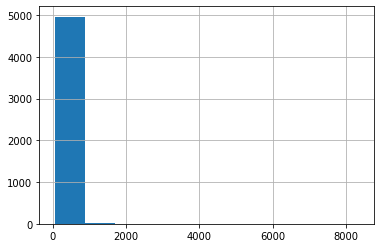

count    5000.000000
mean      161.348400
std       242.597383
min        45.000000
25%        71.000000
50%       105.500000
75%       182.000000
max      8351.000000
dtype: float64

In [17]:
reviews_len = [len(x) for x in merge_df['reviews.text']]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

### Observations:
- Total Records: 5000
- Data Column for building model: reviews.text
- Label Column for identifying class: sentiment
- Unique Reviews: 4385
- Number of Output Class: 3
- __No Null Values for the feature column reviews.text.__

### Analysing the output class distribution in the datasets

Positive    4686
Neutral      197
Negative     117
Name: sentiment, dtype: int64


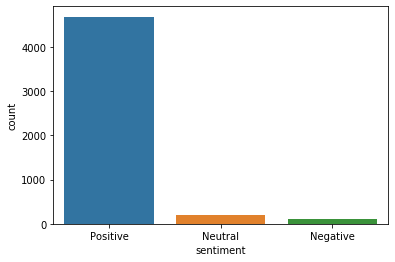

In [18]:
print(merge_df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=merge_df)
plt.show()

### Observations:
> __There is a class imbalance present as `Positive` cases are mostly represented.__

### Data Preprocessing and Cleaning to bring out the context of the sentiments: 
1. __Word Tokenization:__ Extracting words from each reviews.text column
2. __Removal of Stopwords:__ Removing words like `a`, `an`, `the` which are insignificant to sentiment features.
3. __Removal of single character word:__ Single character words donot convey meaning in a sentiment.
4. __Lemmatization:__ Lemmatize and stem both generate the root form of the word except stem may generate a word that doesn’t exist in the dictionary. Lemmatization is used more widely than stemming and also for this project we considering lemmatization.

Completed Word Tokenization
Completed Removal of nltk StopWords
Completed Removal of Words of length = 1
Completed Lemmatization of Words
Completed Joining of the cleaned Text into a record
Analysing Tokens:
Total Tokens: 82161


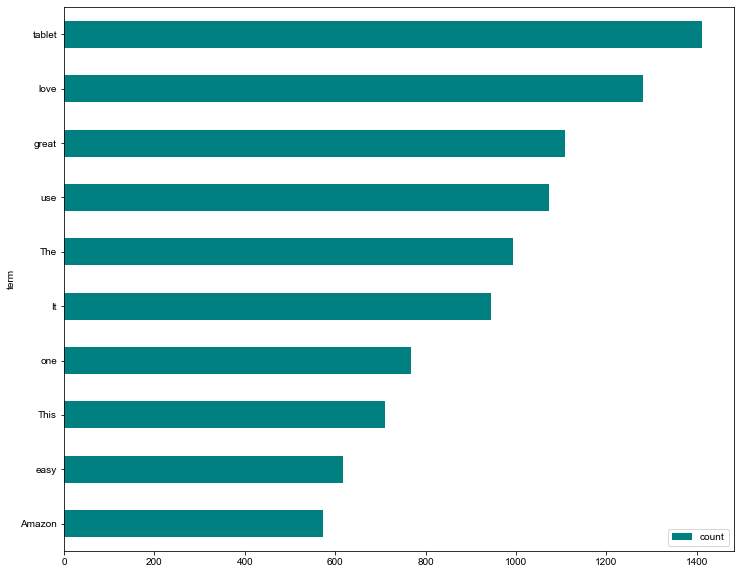

Wall time: 29.7 s


In [19]:
%%time
merge_df['reviews_cleaned'] = preprocess(merge_df['reviews.text'].tolist())

#### Results after preprocessing

In [20]:
merge_df[['reviews.text','reviews_cleaned']][:5]

,reviews.text,reviews_cleaned
0,Purchased on Black FridayPros - Great Price (e...,Purchased Black FridayPros Great Price even sa...
1,I purchased two Amazon in Echo Plus and two do...,purchased two Amazon Echo Plus two dot plus fo...
2,Just an average Alexa option. Does show a few ...,Just average Alexa option Does show thing scre...
3,"very good product. Exactly what I wanted, and ...",good product Exactly wanted good price
4,This is the 3rd one I've purchased. I've bough...,This rd one purchased bought one niece No case...


#### Creating a Training dataset
> 1. For this project, we are using `TfidfVectorizer` to transform the text reviews in numerical form. Other alternatives that can used are CountVectorizer, etc.
>
> 2. The max_features parameter for the vectorizer is set to __2000__, which will generate a sparse matix of 2000 feature columns of the sentiment text.

#### Preparing X_train and y_train for training

In [21]:
X_train, y_train = create_dataset(merge_df, 'reviews_cleaned', 'sentiment', TfidfVectorizer(max_features=2000))

In [22]:
print(X_train.shape)
print(len(y_train))

(5000, 2000)
5000


#### Creating a Test Dataset

In [23]:
validation_df = test_df.copy()
validation_df.insert(7, 'sentiment', test_data_hidden_df['sentiment'])

In [24]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   name               1000 non-null   object
 1   brand              1000 non-null   object
 2   categories         1000 non-null   object
 3   primaryCategories  1000 non-null   object
 4   reviews.date       1000 non-null   object
 5   reviews.text       1000 non-null   object
 6   reviews.title      997 non-null    object
 7   sentiment          1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB


### Preprocessing Test Dataset for predictions

Completed Word Tokenization
Completed Removal of nltk StopWords
Completed Removal of Words of length = 1
Completed Lemmatization of Words
Completed Joining of the cleaned Text into a record
Analysing Tokens:
Total Tokens: 17104


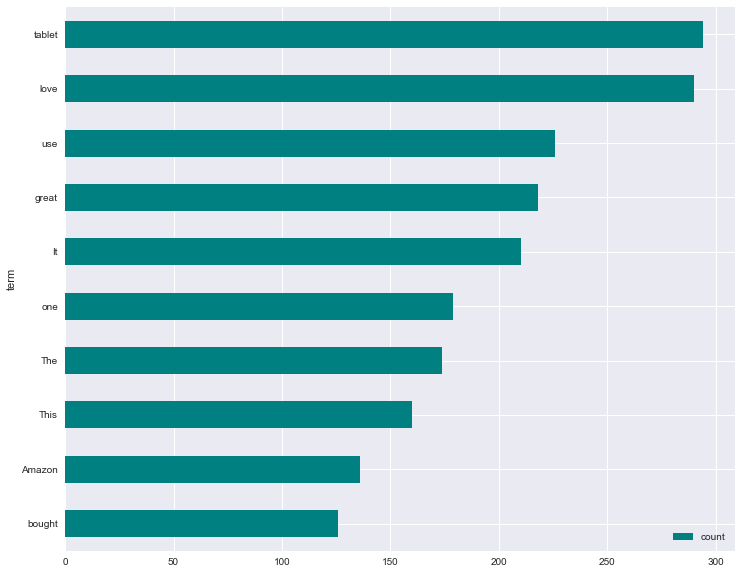

Wall time: 5.92 s


In [25]:
%%time
validation_df['reviews_cleaned'] = preprocess(validation_df['reviews.text'].tolist())

___Results after preprocessing Test Dataset___

In [26]:
validation_df[['reviews.text','reviews_cleaned']][:5]

,reviews.text,reviews_cleaned
0,Amazon kindle fire has a lot of free app and c...,Amazon kindle fire lot free app used one want ...
1,The Echo Show is a great addition to the Amazo...,The Echo Show great addition Amazon family Wor...
2,Great value from Best Buy. Bought at Christmas...,Great value Best Buy Bought Christmas sale
3,"I use mine for email, Facebook ,games and to g...",use mine email Facebook game go line also load...
4,This is a fantastic item & the person I bought...,This fantastic item person bought love


___Class distribution in the Test Dataset___

Positive    937
Neutral      39
Negative     24
Name: sentiment, dtype: int64


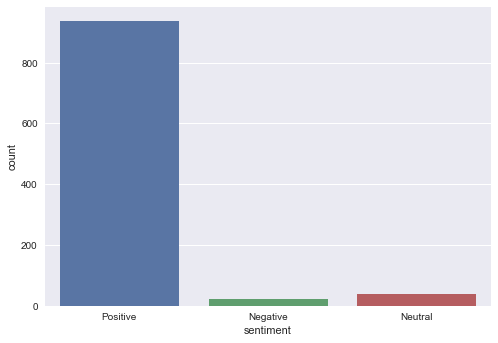

In [27]:
print(validation_df['sentiment'].value_counts())
sns.countplot(x='sentiment', data=validation_df)
plt.show()

#### Preparing X_test and y_test for evaluating the prepared models

In [28]:
X_test, y_test = create_dataset(validation_df, 'reviews_cleaned', 'sentiment', TfidfVectorizer(max_features=2000))

In [29]:
print(X_test.shape)
print(len(y_test))

(1000, 2000)
1000


#### Modeling a Multinomial Nayve Bayes Classifier over the training samples

In [30]:
multi_nb = create_model(X_train, y_train, MultinomialNB())

In [31]:
print(classification_report(y_test, multi_nb.predict(X_test), digits=4))

              precision    recall  f1-score   support

    Negative     0.0000    0.0000    0.0000        24
     Neutral     0.0000    0.0000    0.0000        39
    Positive     0.9376    0.9456    0.9416       937

    accuracy                         0.8860      1000
   macro avg     0.3125    0.3152    0.3139      1000
weighted avg     0.8785    0.8860    0.8822      1000



#### Observations on Multinomial Nayve Bayes Classifier over given training samples
> Because of class imbalance problem all are predicted as positive


### Week 2:
1. Oversampling or undersampling can be used to tackle the class imbalance problem.
2. In case of class imbalance criteria, use the following metrices for evaluating model performance: precision, recall, F1-score, AUCROC curve. Use F1-Score as the evaluation criteria for this project.
3. Use Tree-based classifiers like Random Forest and XGBoost.

> __Note:__ Tree-based classifiers work on two ideologies namely, Bagging or Boosting and have fine-tuning parameter which takes care of the imbalanced class.

Over Sampling and Under Sampling is done through imalanced-learn package execute the below command to setup.
> `pip install imbalanced-learn`

#### Over Sampled Training Data

(14058, 2000)
Positive    4686
Negative    4686
Neutral     4686
Name: 0, dtype: int64


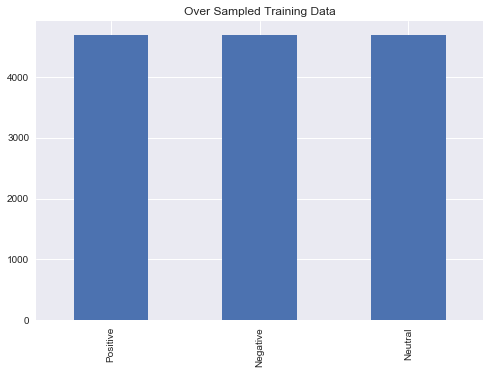

In [32]:
X_train_os, y_train_os = resample_dataset(X_train, y_train, RandomOverSampler())
print(X_train_os.shape)

print(pd.DataFrame(y_train_os)[0].value_counts())
plt.style.use('seaborn')
pd.DataFrame(y_train_os)[0].value_counts().plot(kind='bar', title='Over Sampled Training Data')
plt.show()

#### Over Sampled Test Data

(2811, 2000)
Positive    937
Negative    937
Neutral     937
Name: 0, dtype: int64


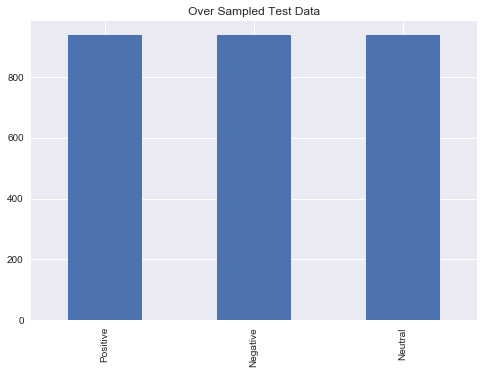

In [33]:
X_test_os, y_test_os = resample_dataset(X_test, y_test, RandomOverSampler())
print(X_test_os.shape)

print(pd.DataFrame(y_test_os)[0].value_counts())
plt.style.use('seaborn')
pd.DataFrame(y_test_os)[0].value_counts().plot(kind='bar', title='Over Sampled Test Data')
plt.show()

#### Under Sampled Training Data

(351, 2000)
Positive    117
Negative    117
Neutral     117
Name: 0, dtype: int64


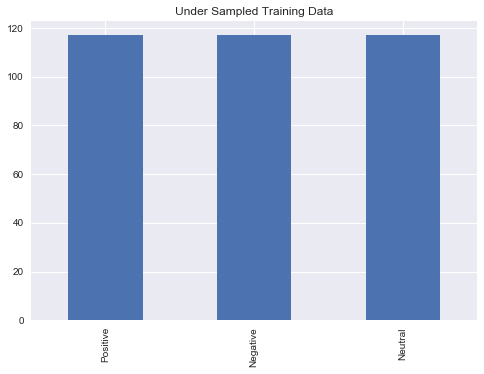

In [34]:
X_train_us, y_train_us = resample_dataset(X_train, y_train, RandomUnderSampler())
print(X_train_us.shape)

print(pd.DataFrame(y_train_us)[0].value_counts())
plt.style.use('seaborn')
pd.DataFrame(y_train_us)[0].value_counts().plot(kind='bar', title='Under Sampled Training Data')
plt.show()

#### Under Sampled Test Data

(72, 2000)
Positive    24
Neutral     24
Negative    24
Name: 0, dtype: int64


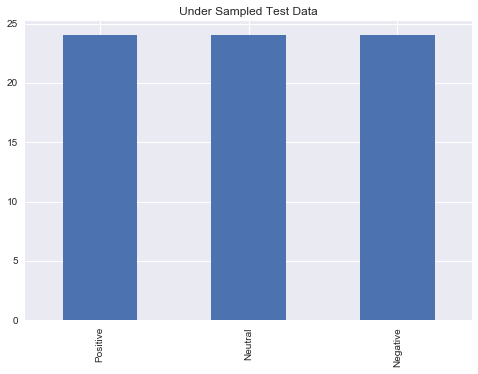

In [35]:
X_test_us, y_test_us = resample_dataset(X_test, y_test, RandomUnderSampler())
print(X_test_us.shape)

print(pd.DataFrame(y_test_us)[0].value_counts())
plt.style.use('seaborn')
pd.DataFrame(y_test_us)[0].value_counts().plot(kind='bar', title='Under Sampled Test Data')
plt.show()

___Creating model and sample collections to compare the sampling strategy with F1 Score___

In [36]:
models = {
            'multinomial_nb': MultinomialNB(),
            'random_forest': RandomForestClassifier(),
            'XGBClassifer': XGBClassifier()
         }

samples = {
            'unsampled': [X_train, y_train, X_test, y_test],
            'over_sampled': [X_train_os, y_train_os, X_test_os, y_test_os],
            'under_sampled': [X_train_us, y_train_us, X_test_us, y_test_us]
        }

In [37]:
def create_models(models, samples):
    model_scores = []
    for model_name, model in models.items():
        for label, sample in samples.items():
            model_scores.append(assess_model_score(model_name, create_model(sample[0], sample[1], model), label, 
                                                              sample[2], sample[3]))
    return pd.DataFrame(model_scores, columns=['Model', 'Sampling', 'F1Score', 'Accuracy', 'Precision', 'Recall'])    

In [38]:
%%time
scores = create_models(models, samples)

Wall time: 7.29 s


In [39]:
scores

,Model,Sampling,F1Score,Accuracy,Precision,Recall
0,multinomial_nb,unsampled,0.882234,0.886000,0.878499,0.886000
1,multinomial_nb,over_sampled,0.292393,0.373888,0.398235,0.373888
2,multinomial_nb,under_sampled,0.294372,0.305556,0.291667,0.305556
3,random_forest,unsampled,0.904523,0.933000,0.877732,0.933000
4,random_forest,over_sampled,0.166266,0.332266,0.110874,0.332266
5,random_forest,under_sampled,0.284275,0.347222,0.448413,0.347222
6,XGBClassifer,unsampled,0.902980,0.929000,0.878378,0.929000
7,XGBClassifer,over_sampled,0.379044,0.419068,0.472945,0.419068
8,XGBClassifer,under_sampled,0.277644,0.319444,0.416667,0.319444


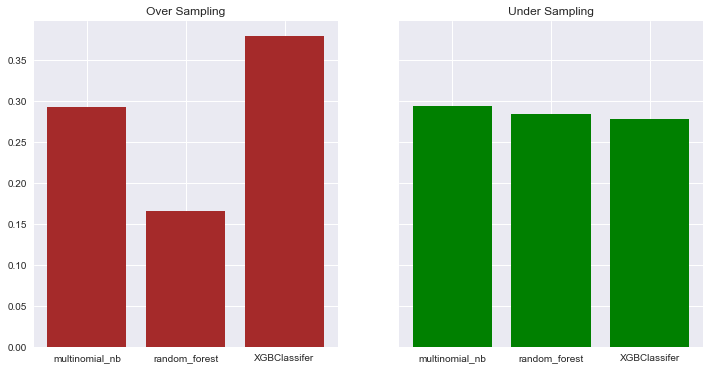

In [40]:
over_sampled = scores[scores['Sampling'] == 'over_sampled']
under_sampled = scores[scores['Sampling'] == 'under_sampled']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), 
                               sharey=True)
ax1.bar(over_sampled['Model'], over_sampled['F1Score'], color="brown")
ax2.bar(under_sampled['Model'], under_sampled['F1Score'], color="green")
ax1.set_title("Over Sampling")
ax2.set_title("Under Sampling")

plt.show()

### Week 3:
1. Apply multi-class SVM’s and neural nets.
2. Use possible ensemble techniques like: XGboost + oversampled_multinomial_NB.
3. Assign a score to the sentence sentiment (engineer a feature called sentiment score). Use this engineered feature in the model and check for improvements. Draw insights on the same.

In [41]:
svm_kernels = {
    'linear': {
        'kernel':'linear', 
        'C':1, 
        'decision_function_shape':'ovo'
    },
    'rbf': {
        'kernel':'rbf', 
        'C':1,
        'gamma':1,
        'decision_function_shape':'ovo'
    },
    'poly': {
        'kernel':'poly', 
        'C':1,
        'degree':3,
        'decision_function_shape':'ovo'
    },
    'sigmoid': {
        'kernel':'sigmoid', 
        'C':1, 
        'decision_function_shape':'ovo'
    }
}
def assess_svm_kernels(samples):
    svm_scores = []
    for label, sample in samples.items():
        for model_name, params in svm_kernels.items():
            model = SVC().set_params(**params).fit(sample[0], sample[1])
            svm_scores.append(assess_model_score(model_name, model, label, sample[2], sample[3]))
    return pd.DataFrame(svm_scores, columns=['SVM_Kernel', 'Sampling', 'F1Score', 'Accuracy', 'Precision', 'Recall'])

In [42]:
%%time
svm_scores = assess_svm_kernels(samples)

Wall time: 37.4 s


In [43]:
svm_scores

,SVM_Kernel,Sampling,F1Score,Accuracy,Precision,Recall
0,linear,unsampled,0.906025,0.936000,0.877910,0.936000
1,rbf,unsampled,0.906525,0.937000,0.877969,0.937000
2,poly,unsampled,0.906525,0.937000,0.877969,0.937000
3,sigmoid,unsampled,0.906025,0.936000,0.877910,0.936000
4,linear,over_sampled,0.225071,0.349342,0.243242,0.349342
5,rbf,over_sampled,0.166667,0.333333,0.111111,0.333333
6,poly,over_sampled,0.166667,0.333333,0.111111,0.333333
7,sigmoid,over_sampled,0.249842,0.334045,0.286376,0.334045
8,linear,under_sampled,0.263680,0.263889,0.268225,0.263889
9,rbf,under_sampled,0.269835,0.305556,0.263844,0.305556


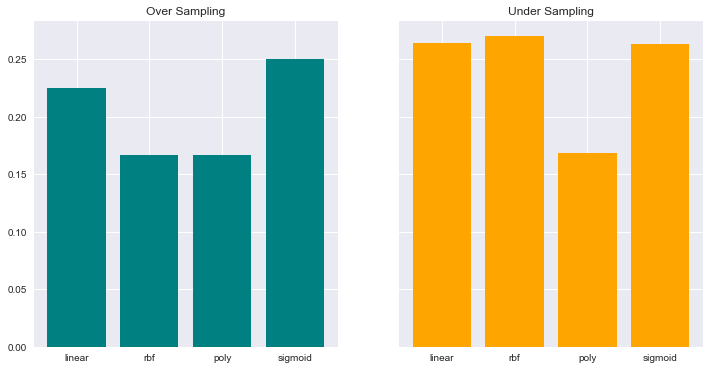

In [44]:
over_sampled = svm_scores[svm_scores['Sampling'] == 'over_sampled']
under_sampled = svm_scores[svm_scores['Sampling'] == 'under_sampled']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), 
                               sharey=True)
ax1.bar(over_sampled['SVM_Kernel'], over_sampled['F1Score'], color="teal")
ax2.bar(under_sampled['SVM_Kernel'], under_sampled['F1Score'], color="orange")
ax1.set_title("Over Sampling")
ax2.set_title("Under Sampling")

plt.show()

#### Adding Sentiment Score using VADER
> __VADER__ ( Valence Aware Dictionary for Sentiment Reasoning) is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion. It is available in the NLTK package and can be applied directly to unlabeled text data.
>
> VADER sentimental analysis relies on a dictionary that maps lexical features to emotion intensities known as sentiment scores. The sentiment score of a text can be obtained by summing up the intensity of each word in the text.
For example- Words like ___‘love’, ‘enjoy’, ‘happy’, ‘like’___ all convey a positive sentiment. Also VADER is intelligent enough to understand the basic context of these words, such as “did not love” as a negative statement. It also understands the emphasis of capitalization and punctuation, such as ___“ENJOY”___

In [45]:
#import nltk
#nltk.download('vader_lexicon')

In [46]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

___Some Examples of VADER Sentiment Inensity Analyzer___

In [47]:
a = 'This was a good movie.'
print(sid.polarity_scores(a))

b = 'This was the best, most awesome movie EVER MADE!!!'
print(sid.polarity_scores(b))

{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}
{'neg': 0.0, 'neu': 0.425, 'pos': 0.575, 'compound': 0.8877}


___Adding Sentiment instenity Compound Score as a feature in our training and test datasets___

#### Training Dataset:

In [48]:
merge_score_df = merge_df[['reviews.text','reviews_cleaned', 'sentiment']]
merge_score_df['sentiment_scores'] = merge_score_df['reviews.text'].apply(lambda review: 
                                                             sid.polarity_scores(review))
merge_score_df['sentiment_compound_score'] = merge_score_df['sentiment_scores'].apply(lambda score_dict: 0 if
                                                               score_dict['compound'] < 0 else score_dict['compound'])
merge_score_df.head()

,reviews.text,reviews_cleaned,sentiment,sentiment_scores,sentiment_compound_score
0,Purchased on Black FridayPros - Great Price (e...,Purchased Black FridayPros Great Price even sa...,Positive,"{'neg': 0.017, 'neu': 0.686, 'pos': 0.297, 'co...",0.9709
1,I purchased two Amazon in Echo Plus and two do...,purchased two Amazon Echo Plus two dot plus fo...,Positive,"{'neg': 0.019, 'neu': 0.781, 'pos': 0.2, 'comp...",0.9716
2,Just an average Alexa option. Does show a few ...,Just average Alexa option Does show thing scre...,Neutral,"{'neg': 0.153, 'neu': 0.847, 'pos': 0.0, 'comp...",0.0000
3,"very good product. Exactly what I wanted, and ...",good product Exactly wanted good price,Positive,"{'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'comp...",0.7496
4,This is the 3rd one I've purchased. I've bough...,This rd one purchased bought one niece No case...,Positive,"{'neg': 0.058, 'neu': 0.866, 'pos': 0.076, 'co...",0.1779


#### Test dataset:

In [49]:
validation_score_df = validation_df[['reviews.text','reviews_cleaned', 'sentiment']]
validation_score_df['sentiment_scores'] = validation_df['reviews.text'].apply(lambda review: 
                                                             sid.polarity_scores(review))
validation_score_df['sentiment_compound_score'] = validation_score_df['sentiment_scores'].apply(lambda score_dict: 0 if 
                                                               score_dict['compound'] < 0 else score_dict['compound'])
validation_score_df.head()

,reviews.text,reviews_cleaned,sentiment,sentiment_scores,sentiment_compound_score
0,Amazon kindle fire has a lot of free app and c...,Amazon kindle fire lot free app used one want ...,Positive,"{'neg': 0.094, 'neu': 0.709, 'pos': 0.197, 'co...",0.3818
1,The Echo Show is a great addition to the Amazo...,The Echo Show great addition Amazon family Wor...,Positive,"{'neg': 0.0, 'neu': 0.418, 'pos': 0.582, 'comp...",0.9944
2,Great value from Best Buy. Bought at Christmas...,Great value Best Buy Bought Christmas sale,Positive,"{'neg': 0.0, 'neu': 0.359, 'pos': 0.641, 'comp...",0.8934
3,"I use mine for email, Facebook ,games and to g...",use mine email Facebook game go line also load...,Positive,"{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...",0.5994
4,This is a fantastic item & the person I bought...,This fantastic item person bought love,Positive,"{'neg': 0.0, 'neu': 0.552, 'pos': 0.448, 'comp...",0.8074


___Recreating Training Datasets with Sentiment Score as a Feature___

In [50]:
X_score_train = csr_matrix(hstack([X_train, np.vstack(merge_score_df['sentiment_compound_score'])]).toarray())
X_score_train_us, y_score_train_us = resample_dataset(X_score_train, y_train, RandomUnderSampler())
X_score_train_os, y_score_train_os = resample_dataset(X_score_train, y_train, RandomOverSampler())

___Recreating Test Datasets with Sentiment Score as a Feature___

In [51]:
X_score_test = csr_matrix(hstack([X_test, np.vstack(validation_score_df['sentiment_compound_score'])]).toarray())
X_score_test_us, y_score_test_us = resample_dataset(X_score_test, y_test, RandomUnderSampler())
X_score_test_os, y_score_test_os = resample_dataset(X_score_test, y_test, RandomOverSampler())

In [52]:
scored_samples = {
    'unsampled': [X_score_train, y_train, X_score_test, y_test],
    'over_sampled': [X_score_train_os, y_train_os, X_score_test_os, y_test_os],
    'under_sampled': [X_score_train_us, y_train_us, X_score_test_us, y_test_us]
}

In [53]:
%%time
scored_models_tests = create_models(models, scored_samples)

Wall time: 7.03 s


In [54]:
scored_models_tests

,Model,Sampling,F1Score,Accuracy,Precision,Recall
0,multinomial_nb,unsampled,0.897231,0.911000,0.883900,0.911000
1,multinomial_nb,over_sampled,0.285073,0.376379,0.409821,0.376379
2,multinomial_nb,under_sampled,0.436232,0.472222,0.492677,0.472222
3,random_forest,unsampled,0.906525,0.937000,0.877969,0.937000
4,random_forest,over_sampled,0.166667,0.333333,0.111111,0.333333
5,random_forest,under_sampled,0.470375,0.527778,0.458700,0.527778
6,XGBClassifer,unsampled,0.905525,0.935000,0.877851,0.935000
7,XGBClassifer,over_sampled,0.479877,0.512273,0.548315,0.512273
8,XGBClassifer,under_sampled,0.544018,0.569444,0.550725,0.569444


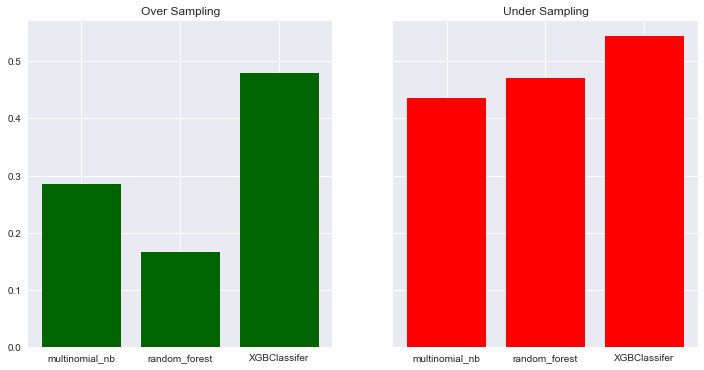

In [55]:
over_sampled = scored_models_tests[scored_models_tests['Sampling'] == 'over_sampled']
under_sampled = scored_models_tests[scored_models_tests['Sampling'] == 'under_sampled']
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), 
                               sharey=True)
ax1.bar(over_sampled['Model'], over_sampled['F1Score'], color="darkgreen")
ax2.bar(under_sampled['Model'], under_sampled['F1Score'], color="red")
ax1.set_title("Over Sampling")
ax2.set_title("Under Sampling")

plt.show()

### Observations:
1. Under Sampling with XGBoost gave a higher F1Score
2. But consistently Over Sampling prooved to be a stable strategy
3. XGBoost classifier is the best model

### Week 4:

1. __Use LSTM__ for the previous problem (use parameters of LSTM like top-word, embedding-length, Dropout, epochs, number of
layers, etc.)

    ___Hint___: Another variation of LSTM, GRU (Gated Recurrent Units) can be tried as well.
    
    
2. __Compare the accuracy__ of neural nets with traditional ML based algorithms.


3. __Find the best setting of LSTM (Neural Net) and GRU__ that can best classify the reviews as positive, negative, and neutral.

    ___Hint:___ Use techniques like Grid Search, Cross-Validation and Random Search

In [56]:
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [57]:
max_fatures = 2000
#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
#tokenizer.fit_on_texts(data['text'].values)
#X = tokenizer.texts_to_sequences(data['text'].values)
#X = pad_sequences(X)

In [58]:
X = X_score_train_os
Y = y_score_train_os

In [59]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2001, 128)         256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 2001, 128)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
Y = pd.get_dummies(Y).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9840, 2001) (9840, 3)
(4218, 2001) (4218, 3)


In [61]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 10, batch_size=batch_size)

Epoch 1/10
9840/9840 [==============================] - 1099s 112ms/step - loss: 1.1003 - accuracy: 0.3326
Epoch 2/10
9840/9840 [==============================] - 1099s 112ms/step - loss: 1.0996 - accuracy: 0.3280
Epoch 3/10
9840/9840 [==============================] - 1102s 112ms/step - loss: 1.0992 - accuracy: 0.3295
Epoch 4/10
9840/9840 [==============================] - 1100s 112ms/step - loss: 1.0991 - accuracy: 0.3340
Epoch 5/10
9840/9840 [==============================] - 1102s 112ms/step - loss: 1.0989 - accuracy: 0.3391
Epoch 6/10
9840/9840 [==============================] - 1102s 112ms/step - loss: 1.0991 - accuracy: 0.3309
Epoch 7/10
9840/9840 [==============================] - 1101s 112ms/step - loss: 1.0988 - accuracy: 0.3339
Epoch 8/10
9840/9840 [==============================] - 1101s 112ms/step - loss: 1.0990 - accuracy: 0.3347
Epoch 9/10
9840/9840 [==============================] - 1102s 112ms/step - loss: 1.0988 - accuracy: 0.3343
Epoch 10/10
9840/9840 [==============

In [62]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 1.10
acc: 0.32


### Week4: Optional
1. __Cluster similar reviews.__

   ___Note:___ Some reviews may talk about the device as a gift-option. Other reviews may be about product looks and some may
   highlight about its battery and performance. Try naming the clusters.
   
   
2. __Perform Topic Modeling__

    ___Hint:___ Use scikit-learn provided Latent Dirchlette Allocation (LDA) and Non-Negative Matrix Factorization (NMF).

In [63]:
import gensim

In [64]:
%%time
review_words = [doc.split(" ") for doc in merge_df['reviews_cleaned'].values]
pprint(review_words[:5], compact=True)

[['Purchased', 'Black', 'FridayPros', 'Great', 'Price', 'even', 'sale', 'Very',
  'powerful', 'fast', 'quad', 'core', 'processor', 'Amazing', 'soundWell',
  'builtCons', 'Amazon', 'ad', 'Amazon', 'need', 'subsidize', 'tablet',
  'remove', 'add', 'pay', 'Inability', 'access', 'apps', 'except', 'one',
  'Amazon', 'There', 'way', 'able', 'accomplish', 'add', 'Google', 'Play',
  'storeNet', 'great', 'tablet', 'money'],
 ['purchased', 'two', 'Amazon', 'Echo', 'Plus', 'two', 'dot', 'plus', 'four',
  'fire', 'stick', 'hub', 'Philips', 'hue', 'lamp', 'family', 'Christmas',
  'happy', 'purchase', 'learning', 'much', 'Alexa', 'You', 'start', 'daily',
  'routine', 'Alexa', 'program', 'whatever', 'would', 'like', 'include', 'news',
  'weather', 'music', 'horoscope', 'ALSO', 'start', 'day', 'compliment',
  'think', 'important', 'Alexa', 'gave', 'BEST', 'CHILI', 'RECIPE', 'MEAN',
  'THE', 'BEST', 'called', 'Chili', 'want', 'husband', 'use', 'Alexa', 'stay',
  'organized', 'business', 'date', 'remind

In [65]:
# Build a Dictionary - association word to numeric id
dictionary = gensim.corpora.Dictionary(review_words)
# Transform the collection of texts to a numerical form
corpus = [dictionary.doc2bow(text) for text in review_words]

In [66]:
NUM_TOPICS = 10
lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary, random_state=1)

In [67]:
print("LDA Model:")
 
for idx in range(NUM_TOPICS):
    # Print the first 10 most representative topics
    pprint("Topic #{}: {}".format(idx, lda_model.print_topic(idx, 10)), compact=True)

LDA Model:
('Topic #0: 0.023*"tablet" + 0.021*"It" + 0.020*"use" + 0.017*"one" + '
 '0.015*"love" + 0.014*"easy" + 0.013*"Kindle" + 0.012*"like" + 0.012*"read" + '
 '0.012*"This"')
('Topic #1: 0.034*"great" + 0.023*"tablet" + 0.018*"This" + 0.014*"like" + '
 '0.011*"wife" + 0.011*"price" + 0.010*"It" + 0.010*"love" + 0.010*"really" + '
 '0.010*"use"')
('Topic #2: 0.028*"tablet" + 0.024*"love" + 0.018*"Amazon" + 0.013*"get" + '
 '0.012*"device" + 0.011*"game" + 0.010*"great" + 0.009*"old" + 0.009*"bought" '
 '+ 0.009*"It"')
('Topic #3: 0.017*"love" + 0.016*"This" + 0.015*"use" + 0.013*"We" + '
 '0.013*"gift" + 0.012*"light" + 0.011*"It" + 0.011*"tablet" + 0.009*"bought" '
 '+ 0.009*"Fire"')
('Topic #4: 0.031*"use" + 0.022*"great" + 0.017*"It" + 0.016*"easy" + '
 '0.014*"love" + 0.012*"product" + 0.009*"The" + 0.009*"music" + 0.009*"Great" '
 '+ 0.009*"set"')
('Topic #5: 0.025*"The" + 0.018*"tablet" + 0.017*"screen" + 0.015*"great" + '
 '0.014*"use" + 0.013*"good" + 0.011*"one" + 0.011*"

In [68]:
# Compute Coherence Score
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=review_words, 
                                                   dictionary=dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.2902470359138623


In [69]:
%%time
NUM_TOPICS = range(2,11)
coherence_lda_scores = []
best_coherence_score = 0
best_lda_model = None

for topic in NUM_TOPICS:
    #Creating the LDA model
    lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=topic, id2word=dictionary, random_state=1)
    
    #Calculating the cohenrence score
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=review_words, 
                                                       dictionary=dictionary, coherence='c_v')
    
    #Collecting the score in tuple
    score = coherence_model_lda.get_coherence()
    coherence_lda_scores.append((topic, score))
    
    if(score > best_coherence_score):
        best_lda_model = lda_model
        best_coherence_score = score

pprint(coherence_lda_scores, compact=True)

[(2, 0.27526690528815523), (3, 0.2963659172243293), (4, 0.279206204646805),
 (5, 0.2857571100389206), (6, 0.3321338931332098), (7, 0.32609793332712084),
 (8, 0.3164261880139445), (9, 0.3201937756769796), (10, 0.2902470359138623)]
Wall time: 1min 4s


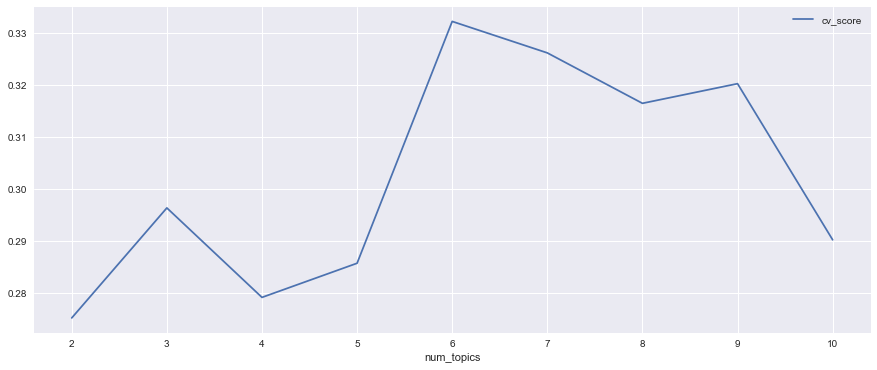

In [70]:
cv_df = pd.DataFrame(coherence_lda_scores, columns=['num_topics', 'cv_score'])
cv_df.plot(x='num_topics',figsize=(15,6))
plt.show()

In [71]:
best_num_topic = int(cv_df.iloc[np.argmax(cv_df['cv_score'])][0]) 
best_cv_score =  cv_df.iloc[np.argmax(cv_df['cv_score'])][1]
print("Optimal Number of Topics: {}, CV Score: {}".format(best_num_topic, best_cv_score))

Optimal Number of Topics: 6, CV Score: 0.3321338931332098


In [72]:
topic = 6
optimal_lda_model = gensim.models.LdaModel(corpus=corpus, num_topics=topic, id2word=dictionary, random_state=1)

In [73]:
topics = optimal_lda_model.show_topics(formatted=False)
pprint(topics, compact=True)

[(0,
  [('tablet', 0.022371216), ('It', 0.018821318), ('love', 0.017786391),
   ('use', 0.014063277), ('one', 0.013042058), ('old', 0.011982092),
   ('bought', 0.011503736), ('year', 0.010966389), ('Kindle', 0.010233204),
   ('easy', 0.0096212635)]),
 (1,
  [('great', 0.024985792), ('tablet', 0.018541802), ('Alexa', 0.01670871),
   ('like', 0.014400253), ('This', 0.014187105), ('sound', 0.010602527),
   ('really', 0.010198714), ('Echo', 0.010081679), ('kid', 0.009802879),
   ('use', 0.008942513)]),
 (2,
  [('love', 0.029577127), ('Amazon', 0.021900546), ('tablet', 0.019859765),
   ('game', 0.011692085), ('device', 0.010956663), ('use', 0.00995144),
   ('bought', 0.00929675), ('get', 0.008598497), ('son', 0.00849916),
   ('kid', 0.008331034)]),
 (3,
  [('love', 0.033134397), ('gift', 0.018169222), ('This', 0.015355146),
   ('bought', 0.012568402), ('We', 0.011348584), ('tablet', 0.011251433),
   ('She', 0.010082228), ('Christmas', 0.0099891145), ('use', 0.009962169),
   ('one', 0.009595

In [74]:
topic_words = {}
for topic_no, words in topics:
    top_words = []
    for word, prob in words:
        top_words.append(word)
    topic_words[topic_no] = top_words

pprint(topic_words, compact=True)

{0: ['tablet', 'It', 'love', 'use', 'one', 'old', 'bought', 'year', 'Kindle',
     'easy'],
 1: ['great', 'tablet', 'Alexa', 'like', 'This', 'sound', 'really', 'Echo',
     'kid', 'use'],
 2: ['love', 'Amazon', 'tablet', 'game', 'device', 'use', 'bought', 'get',
     'son', 'kid'],
 3: ['love', 'gift', 'This', 'bought', 'We', 'tablet', 'She', 'Christmas',
     'use', 'one'],
 4: ['use', 'It', 'great', 'Echo', 'product', 'love', 'Alexa', 'easy', 'would',
     'set'],
 5: ['The', 'tablet', 'great', 'screen', 'one', 'good', 'use', 'price', 'Great',
     'book']}


In [75]:
topic_words_df = pd.DataFrame(topic_words)
topic_words_df

,0,1,2,3,4,5
0,tablet,great,love,love,use,The
1,It,tablet,Amazon,gift,It,tablet
2,love,Alexa,tablet,This,great,great
3,use,like,game,bought,Echo,screen
4,one,This,device,We,product,one
5,old,sound,use,tablet,love,good
6,bought,really,bought,She,Alexa,use
7,year,Echo,get,Christmas,easy,price
8,Kindle,kid,son,use,would,Great
9,easy,use,kid,one,set,book


***Assigning business domain topic names by the analysing the top ten words found by the topic model with highest coherence score.***
> Disclaimer:
> 
> The Topics are assigned based on intuitive understanding of the words distribution for each topic. Actual buisiness interpretation may differ as per requirement.

In [76]:
topic_names = {
    0: "Tablet",
    1: "Sound Quality",
    2: "Gaming Device",
    3: "Gift Item",
    4: "Easy to Use",
    5: "Screen"
}

topic_words_df = topic_words_df.rename(columns = topic_names)
topic_words_df

,Tablet,Sound Quality,Gaming Device,Gift Item,Easy to Use,Screen
0,tablet,great,love,love,use,The
1,It,tablet,Amazon,gift,It,tablet
2,love,Alexa,tablet,This,great,great
3,use,like,game,bought,Echo,screen
4,one,This,device,We,product,one
5,old,sound,use,tablet,love,good
6,bought,really,bought,She,Alexa,use
7,year,Echo,get,Christmas,easy,price
8,Kindle,kid,son,use,would,Great
9,easy,use,kid,one,set,book


In [78]:
doc_topics = []
for bow in review_words:
    doc_topics.append(best_lda_model.get_document_topics(dictionary.doc2bow(bow)))

len(doc_topics)

5000

#### Extracting topic distribution for each reviews from the trained topic model

In [79]:
dominant_topic = [np.argmax([prob for topic, prob in doc_topic]) for doc_topic in doc_topics]
len(dominant_topic)

5000

#### Assigning the dominant topic for each review in the corpus data

In [80]:
data = merge_df.copy()
data['dominant_topic'] = dominant_topic
data.head(10)

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews_cleaned,dominant_topic
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,Purchased Black FridayPros Great Price even sa...,1
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,purchased two Amazon Echo Plus two dot plus fo...,0
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral,Just average Alexa option Does show thing scre...,5
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive,good product Exactly wanted good price,5
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive,This rd one purchased bought one niece No case...,0
5,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2016-12-23T00:00:00.000Z,This is a great product. Light weight. I wish ...,You will love it,Positive,This great product Light weight wish wifi down...,0
6,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-05-31T00:00:00.000Z,My 7-year old daughter saved up to by this. He...,OK For Entry Level Tablet,Neutral,My year old daughter saved Her brother bought ...,1
7,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-06-05T00:00:00.000Z,Purchased this for my son. Has room to upgrade...,Great for kids or smaller needs,Positive,Purchased son Has room upgrade memory allow bo...,0
8,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-11-23T00:00:00.000Z,Bought this for my mom and it was just what sh...,Great tablet,Positive,Bought mom needed great price Been wanting get...,0
9,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-05-18T00:00:00.000Z,"was cheap, can not run chrome stuff, returned ...","was cheap, can not run chrome stuff, returned",Negative,cheap run chrome stuff returned store,2


#### Mapping Topic no with Topic name

In [81]:
data['dominant_topic'] = data['dominant_topic'].map(topic_names)
data.head(10)

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment,reviews_cleaned,dominant_topic
0,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-12-26T00:00:00.000Z,Purchased on Black FridayPros - Great Price (e...,Powerful tablet,Positive,Purchased Black FridayPros Great Price even sa...,Sound Quality
1,Amazon - Echo Plus w/ Built-In Hub - Silver,Amazon,"Amazon Echo,Smart Home,Networking,Home & Tools...","Electronics,Hardware",2018-01-17T00:00:00.000Z,I purchased two Amazon in Echo Plus and two do...,Amazon Echo Plus AWESOME,Positive,purchased two Amazon Echo Plus two dot plus fo...,Tablet
2,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Amazon Echo,Virtual Assistant Speakers,Electro...","Electronics,Hardware",2017-12-20T00:00:00.000Z,Just an average Alexa option. Does show a few ...,Average,Neutral,Just average Alexa option Does show thing scre...,Screen
3,"Fire HD 10 Tablet, 10.1 HD Display, Wi-Fi, 16 ...",Amazon,"eBook Readers,Fire Tablets,Electronics Feature...","Office Supplies,Electronics",2017-08-04T00:00:00.000Z,"very good product. Exactly what I wanted, and ...",Greattttttt,Positive,good product Exactly wanted good price,Screen
4,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-01-23T00:00:00.000Z,This is the 3rd one I've purchased. I've bough...,Very durable!,Positive,This rd one purchased bought one niece No case...,Tablet
5,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2016-12-23T00:00:00.000Z,This is a great product. Light weight. I wish ...,You will love it,Positive,This great product Light weight wish wifi down...,Tablet
6,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-05-31T00:00:00.000Z,My 7-year old daughter saved up to by this. He...,OK For Entry Level Tablet,Neutral,My year old daughter saved Her brother bought ...,Sound Quality
7,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2016-06-05T00:00:00.000Z,Purchased this for my son. Has room to upgrade...,Great for kids or smaller needs,Positive,Purchased son Has room upgrade memory allow bo...,Tablet
8,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2016-11-23T00:00:00.000Z,Bought this for my mom and it was just what sh...,Great tablet,Positive,Bought mom needed great price Been wanting get...,Tablet
9,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-05-18T00:00:00.000Z,"was cheap, can not run chrome stuff, returned ...","was cheap, can not run chrome stuff, returned",Negative,cheap run chrome stuff returned store,Gaming Device


#### Understanding the topic distribution for the entire corpus data

In [82]:
data['dominant_topic'].value_counts(normalize=True)

Tablet           0.3222
Sound Quality    0.1912
Screen           0.1470
Gaming Device    0.1182
Easy to Use      0.1118
Gift Item        0.1096
Name: dominant_topic, dtype: float64

#### Visualising the topic distribution for the entire corpus data

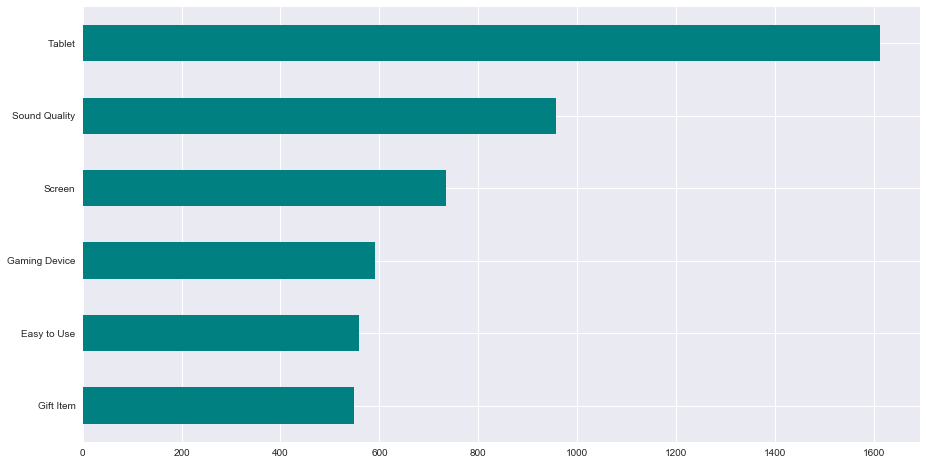

In [83]:
data['dominant_topic'].value_counts().sort_values().plot(kind='barh', figsize=(15,8), color='teal')
plt.show()

#### Understanding the sentiments over each topic for the corpus data

In [84]:
data_topic_sentiment_df = pd.DataFrame(data.groupby(by=['dominant_topic', 'sentiment']).size())

In [85]:
data_topic_sentiment_df = data_topic_sentiment_df.reset_index().rename(columns = {0: 'count'})
data_topic_sentiment_df

,dominant_topic,sentiment,count
0,Easy to Use,Negative,8
1,Easy to Use,Neutral,17
2,Easy to Use,Positive,534
3,Gaming Device,Negative,15
4,Gaming Device,Neutral,15
5,Gaming Device,Positive,561
6,Gift Item,Negative,3
7,Gift Item,Neutral,11
8,Gift Item,Positive,534
9,Screen,Negative,15


#### Visualising the topic wise sentiment distribution for the corpus

In [86]:
labels = topic_names.values()
positive_sentiments = data_topic_sentiment_df[data_topic_sentiment_df['sentiment'] == 'Positive']['count']
negative_sentiments = data_topic_sentiment_df[data_topic_sentiment_df['sentiment'] == 'Negative']['count']
neutral_sentiments = data_topic_sentiment_df[data_topic_sentiment_df['sentiment'] == 'Neutral']['count']

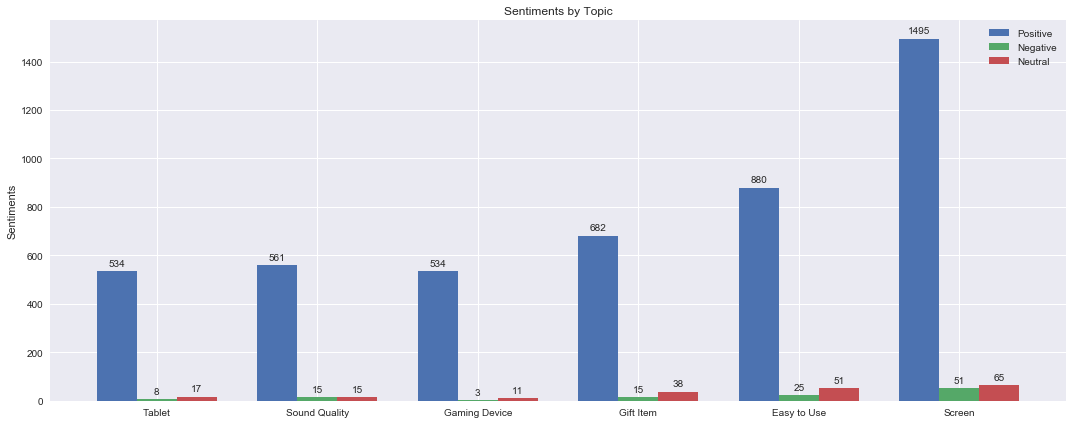

In [87]:
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(15,6))
rects1 = ax.bar(x - width, height=positive_sentiments, width=width, label='Positive')
rects2 = ax.bar(x, height=negative_sentiments, width=width, label='Negative')
rects3 = ax.bar(x + width, height=neutral_sentiments, width=width, label='Neutral')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sentiments')
ax.set_title('Sentiments by Topic')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()